<a id="top"></a>
# Cloud Statistics

<hr>

# Notebook Summary

This notebook explores Landsat 7 and Landsat 8 Data Cubes and reports cloud statistics 
for selected regions within a cube. This is valuable information for performing analyses. 
For example, if there are extensive clouds for a season it may significantly impact the 
mosaic product or index values. Another example is that a user may want to find a single 
date when there are few clouds to assess land features.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Calculate the Cloud Coverage Percentage for Each Pixel](#calc_cloud_coverage)
* [Create a Table of Cloud Coverage Percentage for Each Date](#create_cloud_cov_table)
* [Create a Plot of Cloud Coverage Percentage for Each Date](#plot_cloud_cov)
* [Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period](#pct_clear_img)
* [Review an RGB Scene for a Selected Time Slice](#rgb_time_slice)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

from datacube.utils.aws import configure_s3_access
configure_s3_access(requester_pays=True)

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
3,LANDSAT_8,ls8_l2_c2


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration. Uncomment only 1 set.

# platform = 'LANDSAT_8'
# product = 'ls8_usgs_sr_scene'
# collection = 'c1'
# level = 'l2'

platform = 'LANDSAT_8'
product = 'ls8_l2_c2'
collection = 'c2'
level = 'l2'

In [5]:
band_no_data_values = dc.list_measurements().loc[product, 'nodata']

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_max_dates[0], min_max_dates[1]))))

Latitude Extents: (-2.49930555557555, -0.39847222222541)
Longitude Extents: (36.03375000028827, 38.26208333363943)
Time Extents: ['2013-04-07', '2020-12-04']


**Visualize the available area**

In [7]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [8]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Nairobi, Kenya
latitude = (-1.3407, -1.2809)
longitude = (36.7640, 36.9206)

# Mombasa, Kenya
# latitude = (-4.12, -3.975)
# longitude = (39.55, 39.7) 

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Lake Sulunga, Tanzania
# latitude = (-6.2622, -5.8822) 
# longitude = (34.9802, 35.3602) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Vietnam
# latitude = (10.9358, 11.0358)
# longitude = (107.1899, 107.2899)

# Ghanas
# latitude = (5.5, 5.7)   # Accra
# longitude = (-0.4, 0.0) # Accra

# Time Period
time_extents = ('2016-01-01', '2016-12-31')

**Visualize the selected area**

In [9]:
display_map(latitude,longitude)

## <span id="calc_cloud_coverage">Calculate the Cloud Coverage Percentage for Each Pixel[&#9652;](#top)</span>

In [10]:
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid, landsat_qa_clean_mask

def build_cloud_coverage_table_landsat(product,
                                       platform,
                                       collection,
                                       level,
                                       latitude,
                                       longitude,
                                       time     = None,
                                       dc       = None,
                                       extra_band = 'green',
                                       band_no_data_values = None):
    dc = dc if dc is not None else datacube.Datacube(app = "")
    
    load_params = dict(platform=platform,
                       product=product,
                       latitude = latitude,
                       longitude = longitude,
                       measurements = [extra_band, 'pixel_qa'],
                       group_by='solar_day')
    
    if time is not None: 
        load_params["time"] = time
    
    landsat_dataset = dc.load(**load_params)
    clean_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, 
                                       collection=collection, level=level) & \
                 landsat_clean_mask_invalid(landsat_dataset, platform, collection, level)
    
    data_mask = xr.full_like(clean_mask, True) 
    if band_no_data_values is not None:
        for data_var_name in landsat_dataset.data_vars:
            band_data_mask = landsat_dataset[data_var_name] != band_no_data_values[data_var_name]
            data_mask = data_mask & band_data_mask
    clean_data_mask = clean_mask & data_mask
    
    landsat_dataset = landsat_dataset.where(clean_data_mask)
    
    times = list(landsat_dataset.time.values)
    scene_slice_list = list(map(lambda t: landsat_dataset.sel(time = str(t)), times))
    
    clean_data_mask_list = [clean_data_mask.sel(time=str(time)).values for time in clean_data_mask.time.values]
    # Calculate the percentage of all pixels which are not cloud.
    percentage_list = [clean_data_mask.mean()*100 for clean_data_mask in clean_data_mask_list]
    clean_pixel_count_list = list(map(np.sum, clean_data_mask_list))
    
    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return landsat_dataset, pd.DataFrame(data=data, columns=["times", "clean_percentage", "clean_count"]), \
           clean_mask, data_mask, clean_data_mask

In [11]:
extra_band = 'green'
landsat_dataset, coverage_table, clean_mask, data_mask, clean_data_mask = \
    build_cloud_coverage_table_landsat(product = product,
                                       platform = platform,
                                       collection = collection,
                                       level = level,
                                       latitude = latitude,
                                       longitude = longitude,
                                       time = time_extents,
                                       extra_band=extra_band,
                                       band_no_data_values=band_no_data_values)

## <span id="create_cloud_cov_table">Create a Table of Cloud Coverage Percentage for Each Date[&#9652;](#top)</span>

In [12]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2016-01-08 07:43:14.751607,38.423468,46892
1,2016-01-24 07:43:16.005437,99.895116,121912
2,2016-02-09 07:43:10.930300,52.524582,64101
3,2016-02-25 07:43:04.887145,99.996722,122036
4,2016-03-12 07:43:02.247974,62.191904,75899
5,2016-03-28 07:42:52.830250,69.572271,84906
6,2016-04-13 07:42:47.059260,27.708948,33816
7,2016-04-29 07:42:45.871551,14.404294,17579
8,2016-05-15 07:42:44.210952,72.218945,88136
9,2016-05-31 07:42:50.654685,11.776467,14372


## <span id="plot_cloud_cov">Create a Plot of Cloud Coverage Percentage for Each Date[&#9652;](#top)</span>

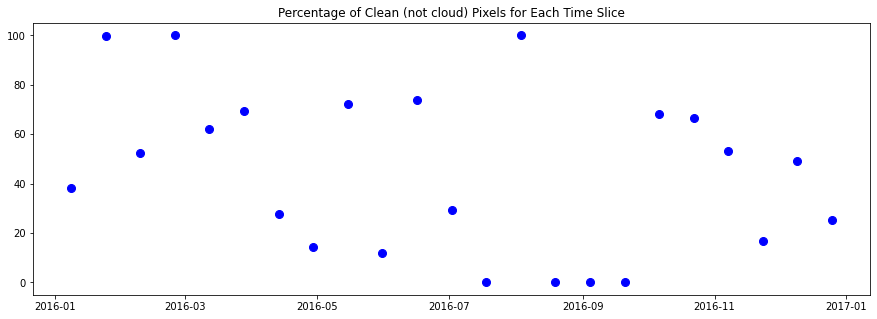

In [13]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.title("Percentage of Clean (not cloud) Pixels for Each Time Slice")
plt.show()

## <span id="pct_clear_img">Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period[&#9652;](#top)</span>

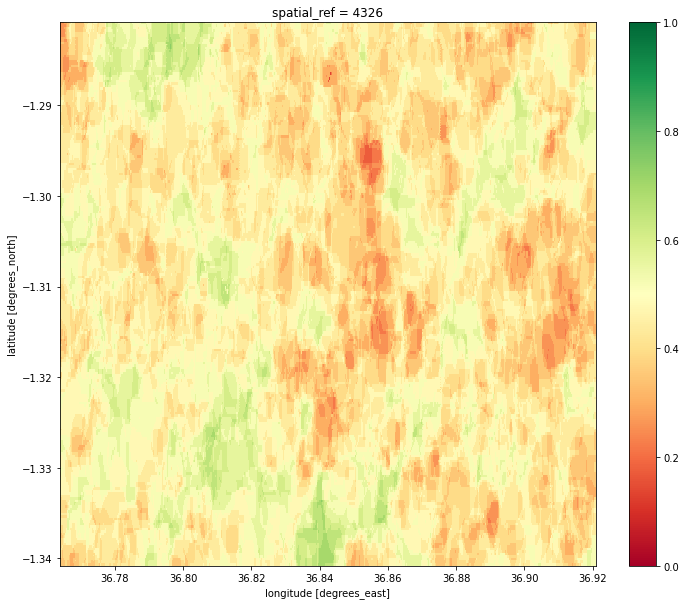

In [14]:
# We are really plotting the fraction of times that are not no_data which are clear.
# This is done to account for regions filled with no_data  - such as when querying across path/rows.
clear_and_data_per_px = clean_data_mask.sum(dim='time')
data_per_px = data_mask.sum(dim='time')
frac_clear_per_data_per_px = clear_and_data_per_px / data_per_px
num_cbar_ticks = 8 # The number of ticks to use for the colorbar.
quad_mesh = (frac_clear_per_data_per_px).plot(figsize=(12,10),cmap = "RdYlGn", vmin=0, vmax=1)
plt.show()

In [15]:
print("Percent of pixels with data: {:.2%}".format(data_mask.mean().values))
print("Percent of pixels that are clear: {:.2%}".format(clean_mask.mean().values))
print("Percent of pixels that are clear and have data: {:.2%}".format(clean_data_mask.mean().values))

Percent of pixels with data: 100.00%
Percent of pixels that are clear: 44.84%
Percent of pixels that are clear and have data: 44.84%


In [16]:
(frac_clear_per_data_per_px == 0).sum() / frac_clear_per_data_per_px.count()
print("Number of pixels which have no non-cloud data:", (frac_clear_per_data_per_px == 0).sum().values)
print("Total number of pixels:", frac_clear_per_data_per_px.count().values)

Number of pixels which have no non-cloud data: 0
Total number of pixels: 122040


## <span id="rgb_time_slice">Review an RGB Scene for a Selected Time Slice[&#9652;](#top)</span>

In [17]:
# Load the data to create an RGB image
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue'],
                          group_by='solar_day')

<p style="color:red";><b>CHANGE INPUTS BELOW

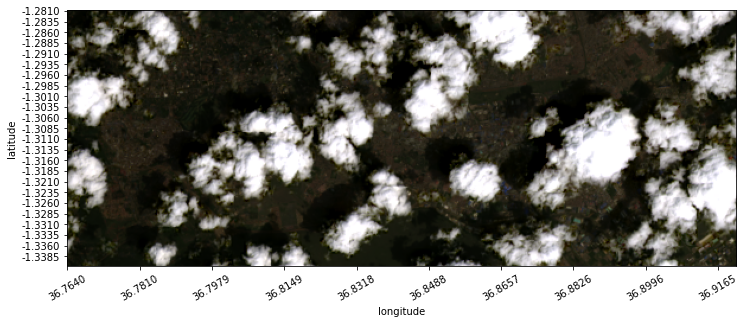

In [18]:
from utils.data_cube_utilities.dc_rgb import rgb
# CHANGE HERE >>>>>>>>>>>>>>

time_ind = 0 # The acquisition to select. The first acquisition has index 0.

# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE and cloud-shadows will be visible in BLACK

rgb(landsat_dataset.isel(time=time_ind), width=12)
plt.show()